In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

year = 2020
names = ['Date', 'TempAvg', 'TempMin', 'TempMax', 'Rain', 'Snow', 'WindDir', 'WindSpeed', 'WindSpeedMax', 'Pressure', 'Sunshine']

In [ ]:
def analize(df):
  print(df.head())
  print(df.describe())
  print(df.head(10))
  print(df.dtypes)
  print(df.shape)

def cleanup(df):
  print(df.isna().sum())
  
  df.dropna(thresh=int(len(df) * 0.2), axis=1, inplace=True)
  
  print(df.isna().sum())
  print(df.shape)

  # df_NoNaN = df.dropna(how='any')

  # print(df_NoNaN.isna().sum())
  # print(df_NoNaN.shape)

  return df.copy()

def plot_NoNaN(df_NoNaN):
  cityName = df_NoNaN['City'].iloc[0]

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=False)
  fig.suptitle(f'{cityName} - {year}')


  ax1.set_title('Temperature')
  plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
  sns.lineplot(data=df_NoNaN, x='Date', y='TempAvg', label='TempAvg', ax=ax1)
  sns.lineplot(data=df_NoNaN, x='Date', y='TempMin', label='TempMin', ax=ax1)
  sns.lineplot(data=df_NoNaN, x='Date', y='TempMax', label='TempMax', ax=ax1)

  if 'Pressure' in df_NoNaN:
    ax2.set_title('Pressure')
    plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    sns.lineplot(data=df_NoNaN, x='Date', y='Pressure', ax=ax2)
  else:
    print('No Pressure data')
  
  if 'WindSpeed' in df_NoNaN or 'WindSpeedMax' in df_NoNaN:
    ax3.set_title('Wind Speed')
    plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))

    if 'WindSpeed' in df_NoNaN:
      sns.lineplot(data=df_NoNaN, x='Date', y='WindSpeed', label='Wind Speed', ax=ax3)
    
    if 'WindSpeedMax' in df_NoNaN:
      sns.lineplot(data=df_NoNaN, x='Date', y='WindSpeedMax', label='Max Wind Speed', ax=ax3)
  else:
    print('No Wind Speed data')

  if 'Rain' in df_NoNaN:
    ax4.set_title('Rain')
    plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    sns.lineplot(data=df_NoNaN, x='Date', y='Rain', ax=ax4)
  else:
    print('No Rain data')
    
  plt.show()


def lagrange_interpolation_manual(x, y, xi):
    """Calculate Lagrange interpolation for xi using given x and y values."""
    n = len(x)
    yi = 0
    for i in range(n):
        Li = 1
        for j in range(n):
            if i != j:
                if x[i] - x[j] < 1e-6:
                    continue
                else:
                    Li *= (xi - x[j]) / (x[i] - x[j])
        yi += Li * y[i]
    return yi

def interpolate_column(series):
    """Interpolate missing values in a Pandas Series using Lagrange interpolation."""
    n = len(series)
    for idx in range(n):
        if pd.isna(series[idx]):
            left_points = series[max(0, idx - 2):idx]
            right_points = series[idx + 1:min(n, idx + 3)]
            
            x = np.array(list(left_points.index) + list(right_points.index))
            y = np.array(list(left_points.values) + list(right_points.values))
            
            # Ensure there are no NaNs in the points used for interpolation
            if np.isnan(y).any():
                continue

            # Interpolate the NaN value
            series[idx] = lagrange_interpolation_manual(x, y, idx)
    return series

def interpolate_dataframe(df):
    for column in df.columns:
        if df[column].dtype in [np.float64, np.int64]:
            df[column] = interpolate_column(df[column])
    return df

def introduce_random_nans(df, nan_fraction=0.05):
    """Introduce random NaNs into the DataFrame."""
    nan_count = int(np.floor(nan_fraction * df.size))
    nan_indices = np.random.choice(df.size, nan_count, replace=False)
    
    flat_df = df.values.flatten()
    flat_df[nan_indices] = np.nan
    
    return pd.DataFrame(flat_df.reshape(df.shape), columns=df.columns)

def calculate_interpolation_error(original_df, interpolated_df):
    error_df = (original_df - interpolated_df).abs()
    error_df = error_df[original_df.isna()]
    return error_df

def plot_interpolation_error(error_df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=error_df)
    plt.title('Interpolation Error Distribution')
    plt.ylabel('Absolute Error')
    plt.show()
    
def plot(df, df_NoNaN, df_WithNaN):
  cityName = df_NoNaN['City'].iloc[0]


  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=False)
  fig.suptitle(f'{cityName} - {year}')

  ax1.set_title('Temperature')
  plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
  sns.lineplot(data=df, x='Date', y='TempAvg', label='TempAvg', ax=ax1)
  sns.lineplot(data=df, x='Date', y='TempMin', label='TempMin', ax=ax1)
  sns.lineplot(data=df, x='Date', y='TempMax', label='TempMax', ax=ax1)
  
  ax2.set_title('Wind Speed')
  plt.xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
  sns.lineplot(data=df, x='Date', y='WindSpeed', label='Wind Speed', ax=ax2)
  sns.lineplot(data=df, x='Date', y='WindSpeedMax', label='Max Wind Speed', ax=ax2)
  
  plt.show()

In [173]:
def read_csv(filename, city_name):
  df = pd.read_csv(filename, delimiter=',', names=names, skiprows=1)  # skipping header row
  df['Date'] = pd.to_datetime(df['Date'])
  df = df[df['Date'].dt.year == year]
  df['City'] = city_name
  return df

In [174]:


# Load the data for multiple cities
df_Krakow = read_csv('Krakow.csv',    'Krakow')
df_Warsaw = read_csv('Warszawa.csv',  'Warszawa')
df_Szczec = read_csv('Szczecin.csv',  'Szczecin')
df_Gdansk = read_csv('Gdansk.csv',    'Gdansk')
df_Podlas = read_csv('Bialystok.csv', 'Bialystok')

city_coords = {
  'Krakow':    (19.94, 50.06),
  'Warszawa':  (21.01, 52.23),
  'Szczecin':  (14.55, 53.43),
  'Gdansk':    (18.65, 54.35),
  'Bialystok': (23.16, 53.13),
}

def run(df):
  df_WithNaN = pd.DataFrame(df)
  analize(df)
  df_NoNaN = cleanup(df)
  plot_NoNaN(df_NoNaN)
  df_with_nans = introduce_random_nans(df_NoNaN.copy(), nan_fraction=0.05)
  df_interpolated = interpolate_dataframe(df_with_nans.copy())
  error_df = calculate_interpolation_error(df, df_interpolated)
  plot_interpolation_error(error_df)
  # plot(df, df_NoNaN, df_WithNaN)


            Date  TempAvg  TempMin  TempMax  Rain  Snow  WindDir  WindSpeed  \
16699 2020-01-01      1.8     -0.8      4.9   0.0   NaN    232.0       16.2   
16700 2020-01-02     -0.8     -4.0      5.3   0.0   NaN    216.0        7.4   
16701 2020-01-03     -0.7     -6.7      5.7   0.0   NaN    208.0        8.7   
16702 2020-01-04      3.7     -0.2      6.1   1.0   NaN    236.0       26.4   
16703 2020-01-05      0.4     -2.8      2.1   2.8  10.0    273.0       18.9   

       WindSpeedMax  Pressure  Sunshine    City  
16699          37.0    1032.9       NaN  Krakow  
16700          22.2    1030.9       NaN  Krakow  
16701          27.8    1024.3       NaN  Krakow  
16702          50.0    1018.5       NaN  Krakow  
16703          44.5    1028.9       NaN  Krakow  
                      Date     TempAvg     TempMin     TempMax        Rain  \
count                  366  366.000000  366.000000  366.000000  359.000000   
mean   2020-07-01 12:00:00    9.864208    5.080055   15.093716    1.8

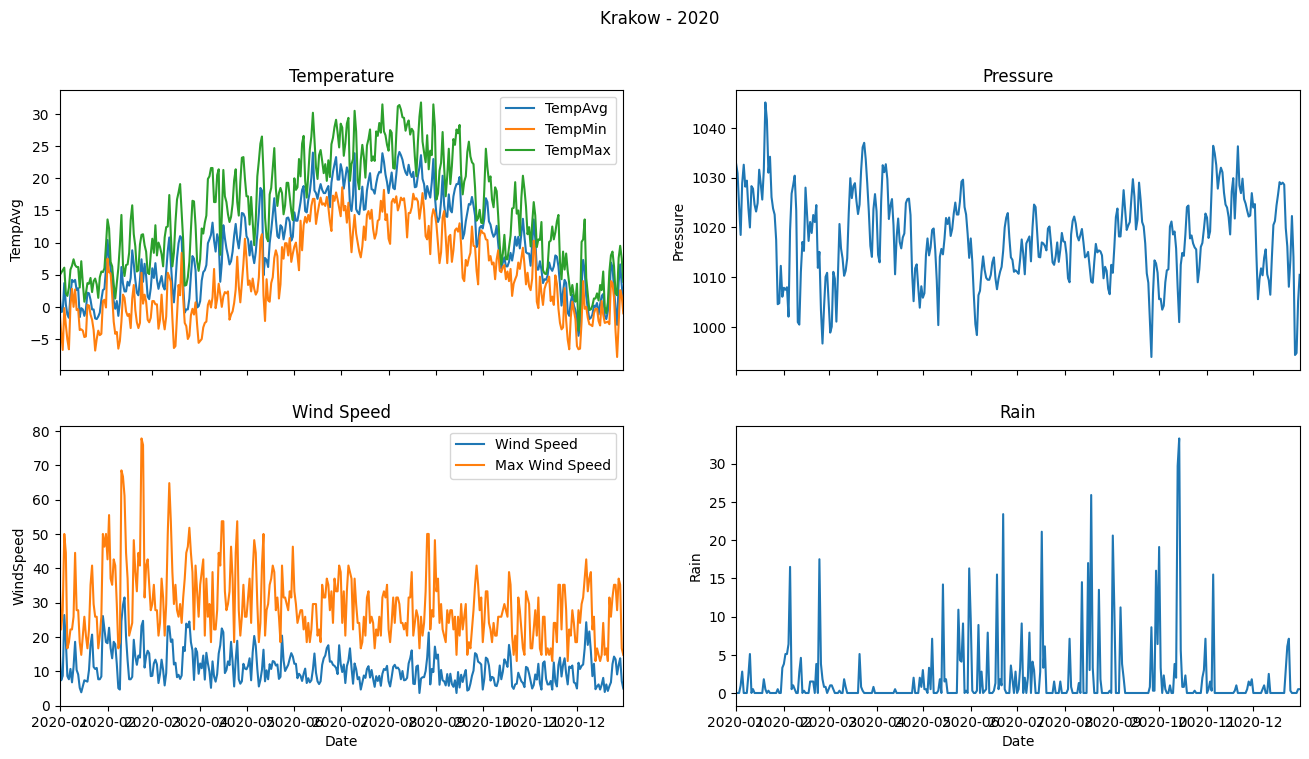

UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

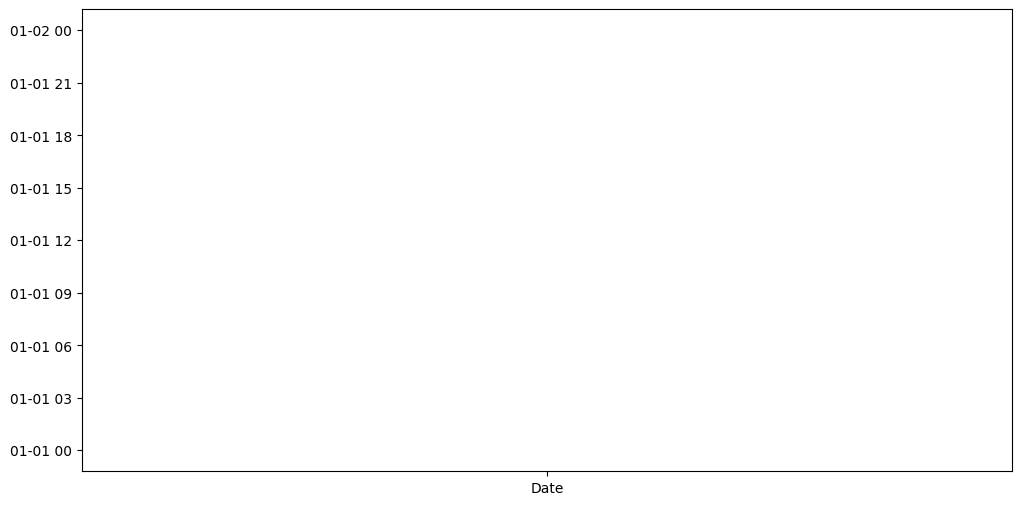

In [175]:
run(df_Krakow)

In [ ]:
# run(df_Warsaw)

In [ ]:
# run(df_Szczec)

In [ ]:
# run(df_Gdansk)

In [ ]:
# run(df_Podlas)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from ipywidgets import interact, widgets

# Concatenate all data into a single DataFrame
data = pd.concat([df_Krakow, df_Warsaw, df_Szczec, df_Gdansk, df_Podlas])

data['lon'] = data['City'].map(lambda city: city_coords[city][0])
data['lat'] = data['City'].map(lambda city: city_coords[city][1])

# Function to create a map for the selected date
def plot_temperature(date):
    df = data[data['Date'] == pd.Timestamp(date)]
    
    if df.empty:
        print(f"No data available for {date}")
        return
    
    # Generate a grid for interpolation
    grid_lon, grid_lat = np.mgrid[14:25:10j, 49:55:10j]
    
    # Interpolate the data onto the grid
    grid_temp = griddata((df['lon'], df['lat']), df['TempAvg'], (grid_lon, grid_lat), method='cubic', rescale=True)
    
    # Create the map
    plt.figure(figsize=(12, 6))

    proj = ccrs.PlateCarree() # LambertAzimuthalEqualArea()


    ax = plt.axes(projection=proj)
    ax.set_extent([14, 25, 49, 55], crs=proj)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    
    # Plot contours with fixed color bar limits and gradient colors
    contour = ax.contourf(grid_lon, grid_lat, grid_temp, 60, transform=proj, cmap='coolwarm')
    plt.colorbar(contour, ax=ax, orientation='vertical', label='Temperature (°C)')
    
    for cityName in city_coords.keys():
        ax.text(city_coords[cityName][0], city_coords[cityName][1], cityName, transform=proj, fontsize=12, verticalalignment='center', color='black', zorder=6)
    
    
    # Add title
    plt.title(f'Temperature Distribution in Poland on {date}')
    
    # Display the map
    plt.show()

# Create a date slider widget
date_slider = widgets.SelectionSlider(
    options=[date.strftime('%Y-%m-%d') for date in pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')],
    description='Date',
    continuous_update=False
)

# Connect the widget to the function
interact(plot_temperature, date=date_slider)

# plot_temperature(f'{year}-01-01')


interactive(children=(SelectionSlider(continuous_update=False, description='Date', options=('2020-01-01', '202…

<function __main__.plot_temperature(date)>